In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("./train.tsv", sep='\t')
test = pd.read_csv("./test.tsv", sep='\t')
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [2]:
import nltk.corpus 
from nltk.corpus import stopwords
import re

def review_to_words(raw_review):
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_review) 
    words = letters_only.lower().split()  
    stops = set(stopwords.words('english'))  
    meaningful_words = [w for w in words if w not in stops] 
    return (" ".join(meaningful_words))

import nltk
nltk.download('stopwords')
clean_train_reviews = []
num_reviews = train["Phrase"].size
for i in range(0, num_reviews):    
    clean_train_reviews.append(review_to_words(train["Phrase"][i]))
print(clean_train_reviews[0])
nltk.download('punkt')
tokenizer = nltk.word_tokenize
word = []
for i in range(len(clean_train_reviews)):  
    word+=(tokenizer(clean_train_reviews[i]))
word_set = list(set(word))  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


series escapades demonstrating adage good goose also good gander occasionally amuses none amounts much story


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
word_df = []
for i in range(len(clean_train_reviews)):  
    word_df.append(tokenizer(clean_train_reviews[i]))
for i in range(len(word_df)):  
    for w in word_df[i]:    
        if w in word_set:
            word_df[i][word_df[i].index(w)] = word_set.index(w)

In [4]:
len_list = []
for i in range(len(word_df)):  
    len_list.append(len(word_df[i]))
max_len = max(len_list)

import numpy as np
features = np.zeros((len(word_df), max_len), dtype=int)
for i in range(len(word_df)):  
    for j in range(len(word_df[i])):    
        features[i][j] = word_df[i][j]
train_labels = np.array([l for l in train['Sentiment']])  

In [5]:
from sklearn.model_selection import train_test_split	
X_train, X_val, y_train, y_val = train_test_split(features, train_labels, test_size=0.3, random_state=42)
print('\t\t\tFeature Shape:')
print('Train Set:\t\t{}'.format(X_train.shape), '\nVal Set:\t\t{}'.format(X_val.shape))

			Feature Shape:
Train Set:		(109242, 30) 
Val Set:		(46818, 30)


In [117]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score

batch_size = 54
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
print(len(train_loader))
print(len(val_loader))
train_on_gpu = torch.cuda.is_available()

class SentimentLSTM(nn.Module):  
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):    
        super(SentimentLSTM, self).__init__()    
        self.output_size = output_size    
        self.n_layers = n_layers    
        self.hidden_dim = hidden_dim    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)    
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)    
        self.dropout = nn.Dropout(0.3)    
        self.fc = nn.Linear(hidden_dim, output_size)
    def forward(self, x, hidden):
    # x_shape = (batch=54, time_step=30, input_size=400)
    # hidden_shape = (n_layers=2, batch=54, hidden_size=256)
    # output_shape = (batch=54, time_step=30, hidden_size=256)
        batch_size = x.size(0)    
        embeds = self.embedding(x)    
        lstm_out, hidden = self.lstm(embeds, hidden)   
        lstm_out = lstm_out.transpose(0,1)   
        lstm_out = lstm_out[-1]  
        out = self.dropout(lstm_out)    
        out = self.fc(out)    
        return out, hidden
    def init_hidden(self, batch_size):    
        weight = next(self.parameters()).data    
        if (train_on_gpu):      
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())    
        else:   
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())            
        return hidden

vocab_size = len(word_set) + 1
output_size = 5
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

lr=0.003
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epoch = 10
counter = 0
print_every = 100
clip = 5  
if(train_on_gpu):  
    net.cuda()
net.train()

list_loss = []
list_step = []
accuracy = []
for e in range(epoch):  
    h = net.init_hidden(batch_size)  
    for inputs, labels in train_loader:    
        counter += 1    
        if train_on_gpu:      
            inputs, labels = inputs.cuda(), labels.long().cuda()    
        h = tuple([each.data for each in h])    
        net.zero_grad()    
        output, h = net(inputs, h)    
        loss = criterion(output, labels)    
        loss.backward()    
        nn.utils.clip_grad_norm_(net.parameters(), clip)   
        optimizer.step()
        if counter % 100 == 0:      
            val_h = net.init_hidden(batch_size)      
            val_losses = []
            accuracy_batch = []
            net.eval()
            for inputs, labels in val_loader:        
                val_h = tuple([each.data for each in val_h])        
                if train_on_gpu:          
                    inputs, labels = inputs.cuda(), labels.long().cuda()        
                output, val_h = net(inputs, val_h)        
                val_h = tuple([each.data for each in val_h])        
                val_loss = criterion(output, labels)        
                val_losses.append(val_loss.item()) 
                output_list = output.tolist()
                output_outcome = []
                label_list = labels.tolist()
                for item in output_list:
                    output_outcome.append(item.index(max(item)))
                accuracy_batch.append(accuracy_score(label_list, output_outcome))
            net.train()      
            print("Epoch: {}/{}...".format(e+1, epoch),            
                "Step: {}...".format(counter),            
                "Loss: {:.6f}...".format(loss.item()),            
                "Val Loss: {:.6f}".format(np.mean(val_losses)))
            list_loss.append(np.mean(val_losses))
            list_step.append(counter)
            accuracy.append(np.mean(accuracy_batch))

2023
867
Epoch: 1/10... Step: 100... Loss: 1.321787... Val Loss: 1.294800
Epoch: 1/10... Step: 200... Loss: 1.346071... Val Loss: 1.300292
Epoch: 1/10... Step: 300... Loss: 1.174657... Val Loss: 1.296359
Epoch: 1/10... Step: 400... Loss: 1.326632... Val Loss: 1.293915
Epoch: 1/10... Step: 500... Loss: 1.459950... Val Loss: 1.300434
Epoch: 1/10... Step: 600... Loss: 1.381058... Val Loss: 1.293539
Epoch: 1/10... Step: 700... Loss: 1.259495... Val Loss: 1.293979
Epoch: 1/10... Step: 800... Loss: 1.187816... Val Loss: 1.235122
Epoch: 1/10... Step: 900... Loss: 1.308912... Val Loss: 1.219159
Epoch: 1/10... Step: 1000... Loss: 1.201130... Val Loss: 1.216840
Epoch: 1/10... Step: 1100... Loss: 1.281916... Val Loss: 1.203312
Epoch: 1/10... Step: 1200... Loss: 1.036847... Val Loss: 1.177551
Epoch: 1/10... Step: 1300... Loss: 1.263402... Val Loss: 1.158783
Epoch: 1/10... Step: 1400... Loss: 1.132258... Val Loss: 1.139698
Epoch: 1/10... Step: 1500... Loss: 1.289691... Val Loss: 1.129572
Epoch: 1/1

Epoch: 7/10... Step: 12500... Loss: 0.698231... Val Loss: 0.912259
Epoch: 7/10... Step: 12600... Loss: 0.867557... Val Loss: 0.927735
Epoch: 7/10... Step: 12700... Loss: 0.660038... Val Loss: 0.893952
Epoch: 7/10... Step: 12800... Loss: 0.686941... Val Loss: 0.911508
Epoch: 7/10... Step: 12900... Loss: 0.577045... Val Loss: 0.921754
Epoch: 7/10... Step: 13000... Loss: 0.786555... Val Loss: 0.900095
Epoch: 7/10... Step: 13100... Loss: 0.602934... Val Loss: 0.926574
Epoch: 7/10... Step: 13200... Loss: 0.546227... Val Loss: 0.925543
Epoch: 7/10... Step: 13300... Loss: 0.744244... Val Loss: 0.902890
Epoch: 7/10... Step: 13400... Loss: 0.781831... Val Loss: 0.895521
Epoch: 7/10... Step: 13500... Loss: 0.619502... Val Loss: 0.903471
Epoch: 7/10... Step: 13600... Loss: 0.748539... Val Loss: 0.904683
Epoch: 7/10... Step: 13700... Loss: 0.728371... Val Loss: 0.898444
Epoch: 7/10... Step: 13800... Loss: 0.836968... Val Loss: 0.949170
Epoch: 7/10... Step: 13900... Loss: 0.980795... Val Loss: 0.90

Text(0.5, 0, 'Step')

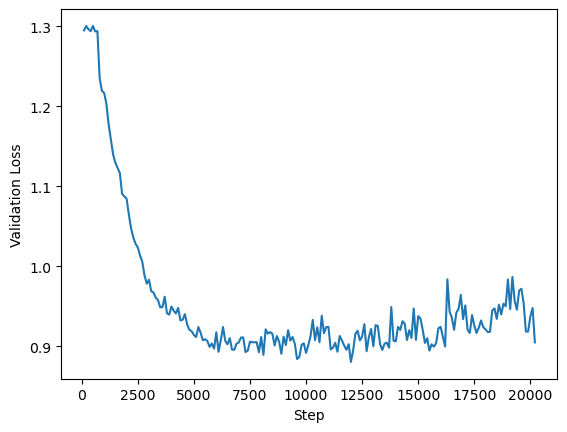

In [118]:
import matplotlib.pyplot as plt
plt.plot(list_step,list_loss)
plt.ylabel('Validation Loss')
plt.xlabel('Step')

Text(0.5, 0, 'Step')

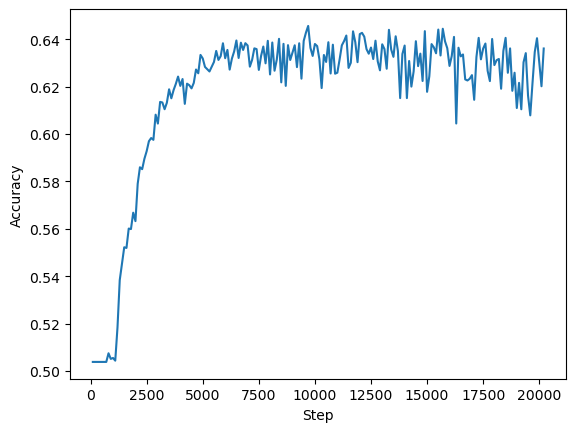

In [119]:
plt.plot(list_step,accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Step')

In [116]:
for p in net.parameters():
    print(p.size())

torch.Size([14993, 400])
torch.Size([1024, 400])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024, 256])
torch.Size([1024, 256])
torch.Size([1024])
torch.Size([1024])
torch.Size([5, 256])
torch.Size([5])
